In [1]:
import torch
import matplotlib.pyplot as plt
from pytorch3d.ops import knn_points
import seaborn as sns
sns.set_theme()

ImportError: /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/pytorch3d-0.7.8-py3.10-linux-x86_64.egg/pytorch3d/_C.cpython-310-x86_64-linux-gnu.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
plantsPositions = torch.rand((10000, 2), dtype=torch.float32, device=device) * 100

plantRadius = torch.tensor(0.2, device=device)

plantsPositions.shape

torch.Size([10000, 2])

In [ ]:
robotPose = torch.tensor([0, 0], dtype=torch.float32, device=device)

torch.Size([100, 100, 2])


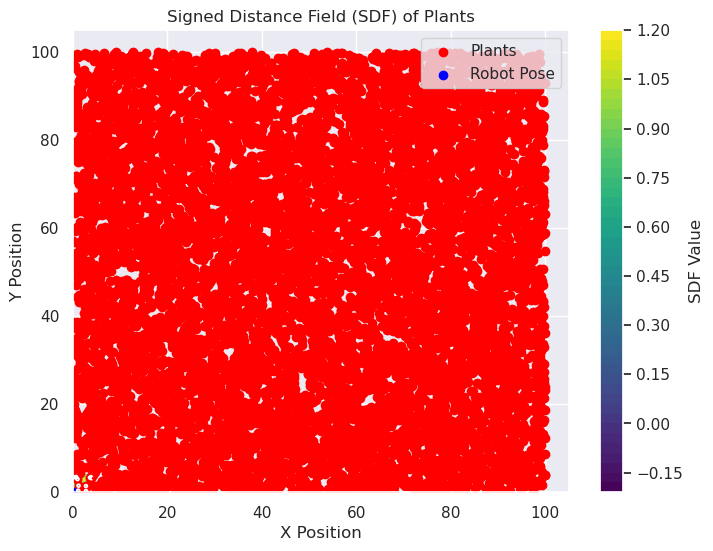

In [ ]:
@torch.jit.script
def sdf(plantCenter, plantRadius, point):
    return torch.norm(plantCenter - point, dim=-1) - plantRadius

@torch.jit.ignore  # PyTorch3D ops are not TorchScript compatible
def sdf_knn(plantsPositions, plantRadius, points):
    # plantsPositions: [num_plants, 2]
    # points: [N, 2]
    # Add a dummy z=0 for 3D compatibility
    plants3d = torch.cat([plantsPositions, torch.zeros(plantsPositions.shape[0], 1, device=plantsPositions.device)], dim=1).unsqueeze(0)  # [1, num_plants, 3]
    points3d = torch.cat([points, torch.zeros(points.shape[0], 1, device=points.device)], dim=1).unsqueeze(0)  # [1, N, 3]
    # Find nearest plant for each point
    knn = knn_points(points3d, plants3d, K=1)
    dists = knn.dists[0].sqrt()  # [N, 1]
    return dists.squeeze(1) - plantRadius 

# Make a 3d plot of the SDF for each plant
def plot_sdf(plantPositions, plantRadius, robotPose):
    x = torch.linspace(0, 4, 100, device=device)
    y = torch.linspace(0, 4, 100, device=device)
    X, Y = torch.meshgrid(x, y)
    Z = torch.ones_like(X, device=device)*99999

    points = torch.stack([X, Y], dim=-1)
    print(points.shape)

    # Vectorized computation for all plants at once
    # points: [100, 100, 2], plantPositions: [9, 2]
    # Expand points to [1, 100, 100, 2], plantPositions to [9, 1, 1, 2]
    points_exp = points.unsqueeze(0)                # [1, 100, 100, 2]
    plants_exp = plantPositions[:, None, None, :]   # [9, 1, 1, 2]
    # Compute SDF for all plants at all points
    sdf_vals = sdf(plants_exp, plantRadius, points_exp) # [9, 100, 100]
    # relu_sdf = torch.relu(sdf_vals)
    Z, _ = torch.min(sdf_vals, dim=0)  # [100, 100]

    plt.figure(figsize=(8, 6))
    plt.contourf(X.cpu().numpy(), Y.cpu().numpy(), Z.cpu().numpy(), levels=50, cmap='viridis')
    plt.colorbar(label='SDF Value')
    plt.contour(X.cpu().numpy(), Y.cpu().numpy(), Z.cpu().numpy(), levels=[0], colors='white', linewidths=2)
    plt.scatter(plantsPositions[:, 0].cpu().numpy(), plantsPositions[:, 1].cpu().numpy(), color='red', label='Plants')
    plt.scatter(robotPose[0].item(), robotPose[1].item(), color='blue', label='Robot Pose')
    plt.title('Signed Distance Field (SDF) of Plants')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.show()

# Plot the SDF
plot_sdf(plantsPositions, plantRadius, robotPose)

Plotting raymarching paths...


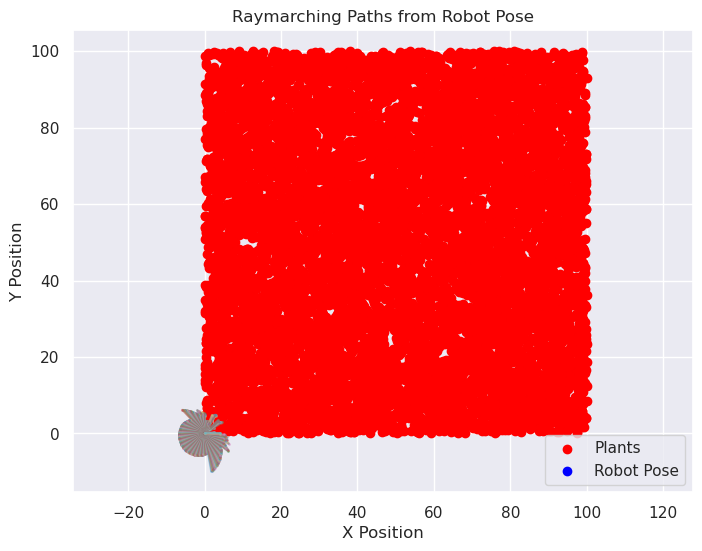

In [ ]:
#Raymarching
@torch.jit.script
def raymarch(start, direction, plantsPositions, plantRadius, max_distance:float=5.0, tolerance:float=1e-2):
    position = start.clone()

    while torch.norm(position - start) < max_distance:
        # Compute the SDF for the current position
        sdf_value = torch.min(sdf(plantsPositions, plantRadius, position))
        
        # If we are inside a plant, stop marching
        if sdf_value < tolerance:
            break
        
        # Move in the direction of the ray
        position += direction * sdf_value

    return position

# Example usage of raymarching
start = robotPose
directionsAngles = torch.linspace(0, 2 * torch.pi, 360, device=device)  # 36 directions
directions = torch.stack([torch.cos(directionsAngles), torch.sin(directionsAngles)], dim=-1)

@torch.jit.script
def computePaths(start, directions, plantsPositions, plantRadius):
    paths = []
    for direction in directions:
        path = raymarch(start, direction, plantsPositions, plantRadius)
        paths.append(path)
    return paths
# Collect paths for each direction

paths = computePaths(start, directions, plantsPositions, plantRadius)

print("Plotting raymarching paths...")

# Plot the raymarching paths
def plot_raymarching(paths, robotPose):
    plt.figure(figsize=(8, 6))
    for path in paths:
        # Each path is a single point (the raymarch endpoint), so plot a line from robotPose to the endpoint
        plt.plot([robotPose[0].item(), path[0].item()], [robotPose[1].item(), path[1].item()], alpha=0.5, marker='o', markersize=1)
    
    plt.scatter(plantsPositions[:, 0].cpu().numpy(), plantsPositions[:, 1].cpu().numpy(), color='red', label='Plants')
    plt.scatter(robotPose[0].item(), robotPose[1].item(), color='blue', label='Robot Pose')
    plt.title('Raymarching Paths from Robot Pose')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Plot the raymarching paths
plot_raymarching(paths, robotPose)




In [ ]:
%timeit computePaths(start, directions, plantsPositions, plantRadius)

In [ ]:
1/200 * 1000

5.0

In [ ]:
#Raymarching
@torch.jit.script
def raymarch_parallel(start, directions, plantsPositions, plantRadius, max_distance:float=5.0, tolerance:float=1e-2, max_steps:int=100):
    # start: [2], directions: [N, 2]
    N = directions.shape[0]
    positions = start.unsqueeze(0).repeat(N, 1)  # [N, 2]
    finished = torch.zeros(N, dtype=torch.bool, device=start.device)  # [N]
    distances = torch.zeros(N, dtype=torch.float32, device=start.device)  # [N]
    for _ in range(max_steps):
        # Compute SDF for all positions
        sdf_min = sdf_knn(plantsPositions, plantRadius, positions)  # [N]

        # Find which rays are done
        hit = (sdf_min < tolerance)
        finished = finished | hit

        # Compute step size for unfinished rays
        step = directions * sdf_min.unsqueeze(1)  # [N, 2]

        # Only update unfinished rays
        positions = torch.where(finished.unsqueeze(1), positions, positions + step)

        distances = torch.where(finished, distances, distances + sdf_min)
        # Stop if all finished or max_distance reached
        if finished.all() or (distances > max_distance).all():
            break
        # Clamp positions that exceed max_distance
        over_max = distances > max_distance
        finished = finished | over_max
    return positions


# Use the parallel version
paths = raymarch_parallel(start, directions, plantsPositions, plantRadius, max_distance=100.0, tolerance=1e-2)

print("Plotting raymarching paths...")

# Plot the raymarching paths
def plot_raymarching(paths, robotPose):
    plt.figure(figsize=(8, 6))
    for path in paths:
        # Each path is a single point (the raymarch endpoint), so plot a line from robotPose to the endpoint
        plt.plot([robotPose[0].item(), path[0].item()], [robotPose[1].item(), path[1].item()], alpha=0.5, marker='o', markersize=1)
    
    plt.scatter(plantsPositions[:, 0].cpu().numpy(), plantsPositions[:, 1].cpu().numpy(), color='red', label='Plants')
    plt.scatter(robotPose[0].item(), robotPose[1].item(), color='blue', label='Robot Pose')
    plt.title('Raymarching Paths from Robot Pose')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Plot the raymarching paths
plot_raymarching(paths, robotPose)




RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/tmp/ipykernel_49228/1052871943.py", line 11, in raymarch_parallel
    for _ in range(max_steps):
        # Compute SDF for all positions
        sdf_min = sdf_knn(plantsPositions, plantRadius, positions)  # [N]
                  ~~~~~~~ <--- HERE

        # Find which rays are done
RuntimeError: RuntimeError: Not compiled with GPU support.

At:
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/pytorch3d-0.7.8-py3.10-linux-x86_64.egg/pytorch3d/ops/knn.py(74): forward
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/torch/autograd/function.py(575): apply
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/pytorch3d-0.7.8-py3.10-linux-x86_64.egg/pytorch3d/ops/knn.py(189): knn_points
  /tmp/ipykernel_49228/817424755.py(13): sdf_knn
  /tmp/ipykernel_49228/1052871943.py(34): <module>
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3579): run_code
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3519): run_ast_nodes
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3336): run_cell_async
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/IPython/core/async_helpers.py(128): _pseudo_sync_runner
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3132): _run_cell
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3077): run_cell
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/ipykernel/zmqshell.py(549): run_cell
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/ipykernel/ipkernel.py(449): do_execute
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/ipykernel/kernelbase.py(778): execute_request
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/ipykernel/ipkernel.py(362): execute_request
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/ipykernel/kernelbase.py(534): process_one
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/asyncio/events.py(80): _run
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/asyncio/base_events.py(603): run_forever
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/tornado/platform/asyncio.py(199): start
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/ipykernel/kernelapp.py(739): start
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/traitlets/config/application.py(1075): launch_instance
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/ipykernel_launcher.py(18): <module>
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/runpy.py(86): _run_code
  /home/airlab/miniconda3/envs/env_isaaclab/lib/python3.10/runpy.py(196): _run_module_as_main



In [ ]:
%timeit raymarch_parallel(start, directions, plantsPositions, plantRadius, max_distance=100)

43.1 ms ± 232 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
1/35 * 1000

28.57142857142857